In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/drive/MyDrive/open.zip"

In [2]:
# 사용 가능한 GPU 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# GPU 사용 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3206212858048645238
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6290407424
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16930135795210318301
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.data import Dataset, experimental
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from datetime import datetime
from PIL import ImageFile

import sys
sys.path.append(os.path.join(os.getcwd(), os.path.pardir, 'functions'))
from get_train_list import get_train_image_paths_and_encoding_labels_fn
from predict_and_test import get_predict_result_fn, get_test_csv_fn
from get_img_tensor_v2 import get_tensor_through_imgs_fn

In [4]:
# ======== 학습용 이미지 경로와 라벨에 대한 각각의 리스트 생성하기 ========

train_image_paths, encoding_labels = get_train_image_paths_and_encoding_labels_fn()

# =====================================================================

encoding_labels.shape : (3457, 19)


In [5]:
# ========= 교수님 코드 따라서 이미지 데이터를 가져오고 차원 변형하기 =========

# 잘린 이미지에 대한 로드 여부 설정
ImageFile.LOAD_TRUNCATED_IMAGES = True

RESIZED_WIDTH = 227
RESIZED_HEIGHT = 227

train_image_tensor = get_tensor_through_imgs_fn(train_image_paths, RESIZED_WIDTH, RESIZED_HEIGHT)
print('train_image_tensor.shape :', train_image_tensor.shape)

# =========================================================================

100%|██████████| 3457/3457 [01:15<00:00, 46.00it/s]


train_image_tensor.shape : (3457, 227, 227, 3)


In [6]:
# ========================== Alexnet 코드 따라서 학습시키기 ==========================
# https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

# Alexnet()
# 데이콘 리더 보드 점수 => 0.384591011

EPOCHS = 50

train_ds = Dataset.from_tensor_slices(
    (train_image_tensor, encoding_labels))

train_ds_size = experimental.cardinality(train_ds).numpy()
print("Training data size:", train_ds_size)

train_ds = (train_ds
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32, drop_remainder=True))

model = Sequential([
    Conv2D(filters=96, kernel_size=(11, 11), strides=(
        4, 4), activation='relu', input_shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(filters=256, kernel_size=(
        5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(
        3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(19, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

model.summary()

model.fit(train_ds,
          epochs=EPOCHS)

# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
model.save(f'model_{now}.h5')

# ===================================================================================


Training data size: 3457
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                               

  0%|          | 0/792 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 1/792 [00:00<03:59,  3.30it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 792/792 [00:17<00:00, 45.80it/s]


normalized_test_image_tensor.shape : (792, 227, 227, 3)
25/25 [==============================] - 5s 41ms/step
predicted_result.shape : (792, 19)
predicted_labels : ['오염', '오염', '곰팡이', '몰딩수정', '훼손', '훼손', '오염', '훼손', '터짐', '오타공', '오타공', '오타공', '오염', '훼손', '훼손', '오염', '오염', '몰딩수정', '훼손', '훼손', '창틀,문틀수정', '걸레받이수정', '훼손', '곰팡이', '꼬임', '훼손', '오염', '오염', '걸레받이수정', '오염', '훼손', '훼손', '훼손', '훼손', '걸레받이수정', '오염', '훼손', '오염', '석고수정', '터짐', '훼손', '꼬임', '터짐', '훼손', '훼손', '오염', '오염', '곰팡이', '오염', '오염', '오타공', '곰팡이', '훼손', '오염', '훼손', '오염', '훼손', '몰딩수정', '오염', '훼손', '오타공', '몰딩수정', '터짐', '오염', '훼손', '오염', '훼손', '걸레받이수정', '훼손', '오염', '훼손', '오염', '훼손', '오염', '오타공', '훼손', '오타공', '훼손', '훼손', '오타공', '꼬임', '훼손', '오염', '오타공', '걸레받이수정', '오염', '꼬임', '오염', '오염', '걸레받이수정', '훼손', '터짐', '훼손', '오타공', '훼손', '오염', '터짐', '오타공', '오염', '훼손', '걸레받이수정', '훼손', '곰팡이', '터짐', '훼손', '훼손', '가구수정', '걸레받이수정', '오염', '훼손', '오염', '훼손', '훼손', '오염', '오염', '훼손', '훼손', '오염', '걸레받이수정', '꼬임', '오염', '오염', '창틀,문틀수정', '곰팡이', '훼손', '훼손', '훼손'

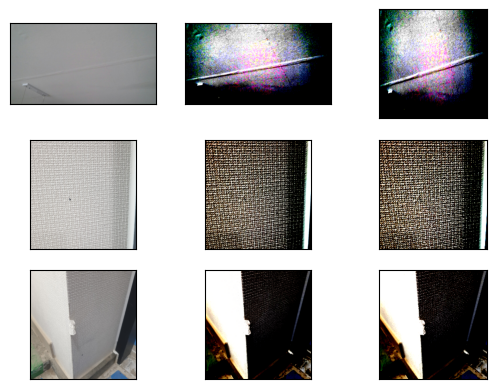

In [7]:
# ================== 테스트 파일로 추론해보기 ==================

predict_result = get_predict_result_fn(RESIZED_WIDTH, RESIZED_HEIGHT, model)
get_test_csv_fn(predict_result)

# ============================================================